Install Scikit-learn into your computational methods environment with `conda install scikit-learn`

In [1]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Part 1: Let's get this data, fam
Load in the breast cancer dataset from Scikit-learn, and perform a random train, validation split on the data. You'll want four variables `X_train`, `X_val`, `Y_train` and `Y_val`.

Tips:
1. Scitkit-learn has a lot of functionality for machine learning projects. Look into how you might get a random training and validation split from your data
2. When you're building your own models a lot of things can go wrong. Like, a lot. And it happens to the best of us. One way you can troubleshoot your models is to use a trivial subset of the entire training data, say ~10 examples, and make sure your model can perfectly learn these examples. I would suggest adding in a switch to allow you to perform testing runs where you reduce your dataset to ~10 examples.

In [2]:
TESTING = False
data = load_breast_cancer()
n = data.data.shape[0]
valFrac = 0.2
X = data.data
Y = data.target.reshape([X.shape[0], 1])
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = valFrac, random_state = 1876)
# Y_train[0:3] = 0
# Y_train[3:4] = 1
if TESTING:
    X_train = X_train[0:10,:]
    X_val = X_train
    Y_train = Y_train[0:10]
    Y_val = Y_train
X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()
Y_train = torch.from_numpy(Y_train).float()
Y_val = torch.from_numpy(Y_val).float()
print("n Train: {}\nn Val: {}".format(X_train.shape[0], X_val.shape[0]))

n Train: 455
n Val: 114


# Part 2: Classification Functions

## Logistic Regression
Logistic regression is your bread and butter baseline classification model. Before implementing anything too fancy, you should see how far logistic regression can get you. When should you use logistic regression? Whenever you're performing supervised learning and have a binary response variable (only two classes). Luckily for us, most of the math for a logistic regression model has already been worked out in Lab 3 with linear regression. But there's just one problem, linear regression is unbounded, and if we're doing classification we want our model to predict the probability of a model belonging to one class or the other. So instead of letting our model's outputs be between $-\infty$ and $\infty$ we want to constrain it between $0$ and $1$.

To blatantly plagiarize another TAs work, in least squares linear regression we have a feature matrix $X$ and a set of corresponding outcomes $Y$, and the goal is to learn a $\beta$ such that $\hat{Y} = X^\top \beta + \epsilon$ minimizes the loss function $\sum_i (Y - \hat{Y})^2$, with $\mathbb{E}[\epsilon] = 0$.

Using the input $X$ and our model parameters $\beta$ we'll convert linear regression into logistic regression. First, why do we want to bound our model between $0$ and $1$? Because we're doing classification we need an easy way to define when our prediction is for one class or the other, and if our model can only output probabilities then we can use a cutoff (say $0.5$) and bin every observation into a class. Squashing inputs between $0$ and $1$ is done using the sigmoid function $\sigma(a) = \frac{1}{1 + exp(-a)}$. Using our inputs $X$, our learned parameters $\beta$ and $\sigma(\cdot)$ we have the makings of greatness, or at least some kind of baseline model. We write the probability of our 'positive' class (an arbiterary designation) as $$p(Y = 1|X;\beta) = \sigma(\beta^{T}X)$$ and our 'negative' class as $$p(Y = 0|X;\beta) = 1 - \sigma(\beta^{T}X)$$. For simplicity's sake let $a = beta^{T}X$ for he remainder of this cell

The loss function for logistic regression is similar to what we used in Lab 2 for MLE. For a single observation $x_i$ and its response variable $y_i$ we define our prediction's loss as $L(\beta;y_i, x_i) = \sigma(a)^{i_i}(1 - \sigma(a))^{1-y_i}$. And for an entire dataset of $n$ examples after taking the log our loss is

$$\frac{1}{n}\sum_{i=1}^n y_ilog(\sigma(a)) + (1-y_i)log(1-\sigma(a))$$

Using our usual tools of gradient descent, and stochastic gradient descent we can now learn the parameters $\beta$ which minimize our loss


In [3]:
class binaryClassifier(nn.Module):
    """
        A general classifier that can use multiple activation functions, or none at all.
        By making the activation function we use an argument during initialization we don't
        have to make a different function every time we want to change up the activation
        function. We want to also have the option of having no activation function, so the 
        model behaves just like a linear regression without an activation function.
    """
    # The class constructor defines the parameters (ie layers) of the neural network
    # add an init function which allows us to pass in arbitrary activation functions
    # and defaults to None.
    
    
    #### your code here ####
    def __init__(self, nFeats, activationFunction = None):
    #### end your code ####
    
    
        super(binaryClassifier, self).__init__()
        # What type of parameters do we need to add?
        
        
        self.linear = nn.Linear(in_features = nFeats, out_features = 1)
        # Do not remove the line below. It allows the model to learn by initializing small weights
        self.linear.weight= torch.nn.init.xavier_uniform_(self.linear.weight, gain = 0.001)
        
        
        # Store the activation function in our object
        #### your code here ####
        self.activationFunction = activationFunction
        #### end your code ####
        
        
        
    def forward(self, x):
        # Write a forward pass function which optionally uses the activation function
        #### your code here ####
        if self.activationFunction is None:
            out = self.linear(x)
        else:
            out = self.activationFunction(self.linear(x))
        return(out)
        #### end your code ####

In [4]:
# Initialize a binaryClassifier object, with the appropriate loss function from torch.nn.
# Tip: Pytorch defines multiple loss functions. Look them up and see which one is in line
    # with the loss function we defined for a logistic regression model
#### your code here ####
logisticRegressionModel = binaryClassifier(nFeats = X_train.shape[1], activationFunction = None)
lossFunction = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(logisticRegressionModel.parameters(), lr = .00001, momentum = 0.9)
#### end your code ####

### Learning our logistic model
Now we're ready to learn our model. Using the skeleton code below fill in what you'll need to perform a forward pass, calculate the loss, and update the parameters at each epoch. **Keep track of and plot your training and validation loss at each step** after the model converges

In [5]:
epochs = 2000
logisticLossVal = []
logisticLossTrain = []
for epoch in range(epochs):
    #### your code here ####   
    # Estimate Y_hat with the current model
    Y_hat = logisticRegressionModel(X_train)
    
    # Compute the training
    loss = lossFunction(Y_hat, Y_train)
    logisticLossTrain.append(loss.data.numpy())
    # compute the validation loss and store it.
    valLoss = lossFunction(logisticRegressionModel(X_val), Y_val)
    logisticLossVal.append(valLoss.data.numpy())
    # Compute the gradient of the loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print("loss {}, val loss {}".format(np.round(loss.data.numpy(), decimals = 2),
                                           np.round(valLoss.data.numpy(), decimals = 2)))
#### end your code ####

loss 0.6899999976158142, val loss 0.699999988079071
loss 0.25, val loss 0.23999999463558197
loss 0.23000000417232513, val loss 0.20999999344348907
loss 0.2199999988079071, val loss 0.20000000298023224
loss 0.20999999344348907, val loss 0.1899999976158142
loss 0.20999999344348907, val loss 0.1899999976158142
loss 0.20999999344348907, val loss 0.1899999976158142
loss 0.20999999344348907, val loss 0.1899999976158142
loss 0.20000000298023224, val loss 0.1899999976158142
loss 0.20000000298023224, val loss 0.1899999976158142
loss 0.20000000298023224, val loss 0.1899999976158142
loss 0.20000000298023224, val loss 0.1899999976158142
loss 0.20000000298023224, val loss 0.18000000715255737
loss 0.20000000298023224, val loss 0.18000000715255737
loss 0.20000000298023224, val loss 0.18000000715255737
loss 0.20000000298023224, val loss 0.18000000715255737
loss 0.20000000298023224, val loss 0.18000000715255737
loss 0.1899999976158142, val loss 0.18000000715255737
loss 0.1899999976158142, val loss 0.18

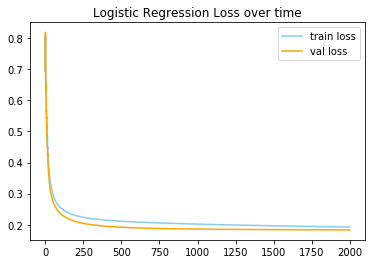

In [6]:
plt.plot(logisticLossTrain, color = "skyblue", label = "train loss")
plt.plot(logisticLossVal, color = 'orange', label = "val loss")
plt.legend()
plt.title("Logistic Regression Loss over time")
plt.show()

## Probit Model

We defined $p(Y = 1|a) = \sigma(a)$ in logistic regression, but the more general form of a linear model would be $p(Y = 1|X;\beta) = f(\beta^{T}X)$ where $f(\cdot)$ is known as an activation function. Another activation function we could have used is known as the inverse probit function which is the cumulative distribution function of a standard normal defined as $\Phi(a) = \frac{1}{2}(1 + erf(\frac{1}{\sqrt{2}}))$ (Did you hear that? That was the sound of an absolute ton of details being skipped over. For more information about probit regression go to page 210 [here](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf)). Here $erf(\cdot)$ is known as the error function. All the same steps apply for the logistic regression example, except instead of $\sigma(\cdot)$ we use $\Phi(\cdot)$

$$\frac{1}{n}\sum_{i=1}^n y_ilog(\Phi(a)) + (1-y_i)log(1-\Phi(a))$$



Tips:
1. For the love of your weekend don't try to implement the CDF of a normal distribution. Search around and find out how you can get the cdf of different distributions in using Pytorch.

In [13]:
# Initialize a binaryClassifier object, with the appropriate loss function from torch.nn, and the
# activation function discussed above.
# Tip: If you notice the model is not learning, or the loss is going up, try tuning the learning rate
#### your code here ####
normDist = torch.distributions.normal.Normal(0, 1)
probitRegressionModel = binaryClassifier(nFeats = X_train.shape[1], activationFunction = normDist.cdf)
lossFunction = nn.BCELoss()
optimizer = torch.optim.SGD(probitRegressionModel.parameters(), lr = .000001, momentum = 0.9)
#### end your code ####

### Learning our probit model
Now we're ready to learn our model. Using the skeleton code below fill in what you'll need to perform a forward pass, calculate the loss, and update the parameters at each epoch. **Keep track of and plot your training and validation loss at each step** after the model converges

In [14]:
epochs = 2000
probitLossTrain = []
probitLossVal = []
for epoch in range(epochs):
    #### your code here ####
    # Estimate Y_hat with the current model
    
    Y_hat = probitRegressionModel(X_train)
    
    # Compute the loss
    loss = lossFunction(Y_hat, Y_train)
    probitLossTrain.append(loss.data.numpy())
    # compute the validation loss and store it.
    valLoss = lossFunction(probitRegressionModel(X_val), Y_val)
    probitLossVal.append(valLoss.data.numpy())
    
    # Compute the gradient of the loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print("loss {}, val loss {}".format(np.round(loss.data.numpy(), decimals = 2),
                                           np.round(valLoss.data.numpy(), decimals = 2)))
    #### end your code ####

loss 0.6600000262260437, val loss 0.6499999761581421
loss 0.3499999940395355, val loss 0.33000001311302185
loss 0.28999999165534973, val loss 0.27000001072883606
loss 0.25999999046325684, val loss 0.25
loss 0.25, val loss 0.23000000417232513
loss 0.23999999463558197, val loss 0.2199999988079071
loss 0.23000000417232513, val loss 0.20999999344348907
loss 0.23000000417232513, val loss 0.20999999344348907
loss 0.2199999988079071, val loss 0.20000000298023224
loss 0.2199999988079071, val loss 0.20000000298023224
loss 0.2199999988079071, val loss 0.20000000298023224
loss 0.2199999988079071, val loss 0.20000000298023224
loss 0.20999999344348907, val loss 0.20000000298023224
loss 0.20999999344348907, val loss 0.1899999976158142
loss 0.20999999344348907, val loss 0.1899999976158142
loss 0.20999999344348907, val loss 0.1899999976158142
loss 0.20999999344348907, val loss 0.1899999976158142
loss 0.20999999344348907, val loss 0.1899999976158142
loss 0.20999999344348907, val loss 0.1899999976158142

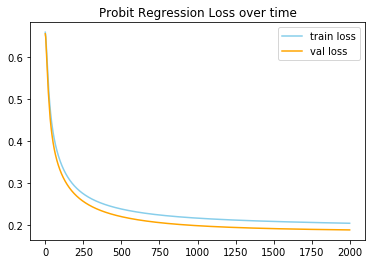

In [15]:
plt.plot(probitLossTrain, color = "skyblue", label = "train loss")
plt.plot(probitLossVal, color = 'orange', label = "val loss")
plt.legend()
plt.title("Probit Regression Loss over time")
plt.show()

## Hinge Loss
We can also change the loss function we use in logistic regression to the hinge loss by reconfiguring how we view the data. To do this we formulate our response variable as either $-1$ or $1$. Now, $p(Y = 1|X;\beta) = \sigma(a)$ remains unchanged, but $p(Y = -1|X;\beta) = 1 - \sigma(a) = \sigma(-a) = \sigma(ya)$. In the last step recall that $Y \in \{-1, 1\}$ so $p(Y|X;\beta) = \sigma(ya)$

Using the negative log likelihood and our updated probability functions our loss now becomes:

$$\frac{1}{n}\sum_{i=1}^{n}-log(\sigma(ya))$$

In [16]:
#### your code here ####
def myHingeLoss(a, y):
    m = nn.LogSigmoid()
    out = -m(a*y)
    out = torch.mean(out)
    return(out)
#### end your code ####

In [17]:
# Initialize a binaryClassifier object, with the loss function defined above.
#### your code here ####
logisticRegressionHingeModel = binaryClassifier(nFeats = X_train.shape[1], activationFunction = None)
lossFunction = myHingeLoss
optimizer = torch.optim.SGD(logisticRegressionHingeModel.parameters(), lr = .00001, momentum = 0.9)
#### end your code ####

In [18]:
# The hinge loss model requires our data is -1 or 1.
Y_train_hinge = Y_train.clone().detach()
Y_train_hinge[Y_train_hinge == 0] = -1
Y_val_hinge = Y_val.clone().detach()
Y_val_hinge[Y_val_hinge == 0] = -1

### Learning our hinge loss model
Now we're ready to learn our model. Using the skeleton code below fill in what you'll need to perform a forward pass, calculate the loss, and update the parameters at each epoch. **Keep track of and plot your training and validation loss at each step** after the model converges

In [19]:
epochs = 1500
logisticHingeLossTrain = []
logisticHingeLossVal = []
for epoch in range(epochs):
    #### your code here ####
    # Estimate Y_hat with the current model
    
    Y_hat = logisticRegressionHingeModel(X_train)
    
    # Compute the loss
    loss = lossFunction(Y_hat,Y_train_hinge)
    logisticHingeLossTrain.append(loss.data.numpy())
    # compute the validation loss and store it.
    valLoss = lossFunction(logisticRegressionHingeModel(X_val), Y_val_hinge)
#     if epoch % 100 == 0:
#         print(valLoss)
    logisticHingeLossVal.append(valLoss.data.numpy())        
    # Compute the gradient of the loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print("loss {}, val loss {}".format(np.round(loss.data.numpy(), decimals = 2),
                                           np.round(valLoss.data.numpy(), decimals = 2)))
    #### end your code ####

loss 0.7200000286102295, val loss 0.7300000190734863
loss 0.25999999046325684, val loss 0.23999999463558197
loss 0.23000000417232513, val loss 0.20999999344348907
loss 0.2199999988079071, val loss 0.20000000298023224
loss 0.2199999988079071, val loss 0.20000000298023224
loss 0.20999999344348907, val loss 0.1899999976158142
loss 0.20999999344348907, val loss 0.1899999976158142
loss 0.20999999344348907, val loss 0.1899999976158142
loss 0.20999999344348907, val loss 0.1899999976158142
loss 0.20000000298023224, val loss 0.1899999976158142
loss 0.20000000298023224, val loss 0.1899999976158142
loss 0.20000000298023224, val loss 0.1899999976158142
loss 0.20000000298023224, val loss 0.1899999976158142
loss 0.20000000298023224, val loss 0.1899999976158142
loss 0.20000000298023224, val loss 0.1899999976158142


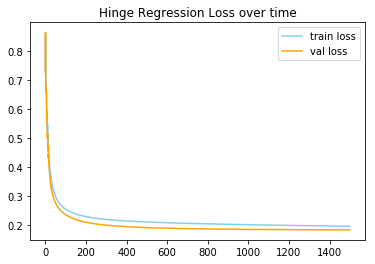

In [20]:
plt.plot(logisticHingeLossTrain, color = "skyblue", label = "train loss")
plt.plot(logisticHingeLossVal, color = 'orange', label = "val loss")
plt.legend()
plt.title("Hinge Regression Loss over time")
plt.show()